# A Simple Machine Learning Model For Predicting The Biological Activities of Candidate Ligands

## Prelude
Pancreatic lipase (PL) inhibitors are important for regulating fat metabolism in the body. PL breaks down dietary fats into smaller molecules like glycerol and fatty acids, which the body then absorbs and uses to make new fats. Because of this, finding and developing PL inhibitors can help control fat breakdown from the start and may be useful for managing obesity.

## The QSAR method
Quantitative Structure-Activity Relationship (QSAR) is a computational approach used to predict the biological activity or toxicity of chemical compounds based on their structural properties. The fundamental principle underlying QSAR is that structurally similar molecules are likely to have similar physicochemical and biological properties. The QSAR model relates a quantitative measure of chemical structure to a physical property or a biological activity, using mathematical equations or statistical models.

The core principle of QSAR is similar to any other data science project using supervised learning. You start by collecting and curating a training dataset, you build a model, you evaluate the model and finally, you deploy the model. 

### Conceptualization
Sketch a workflow to conduct QSAR prediction in the form of a diagram. 

### Preparing the computational environment
The practical uses:
* `pandas` to wrangle and manipulate data
* `matplotlib`, for plotting
* `scikit-learn`, to make the machine learning prediction
* `rdkit`, to process chemical data
* `tqdm`, for monitoring progression
* `chembl_webressource_client`: to perform data mining [(Davies et al, 2015)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4489243/)
* `padelpy`, for calculating chemical descriptors [(Yap, 2010)](https://onlinelibrary.wiley.com/doi/10.1002/jcc.21707)
* `mordred`, to calculate chemical descriptors [(Moriwaki et al, 2018)](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y)

In [ ]:
!pip install pandas matplotlib scikit-learn tqdm
!pip install rdkit mordred chembl_webresource_client padel-pywrapper

### Collecting data

ChemBL is a manually curated database of bioactive molecules with drug-like properties, containing over 1.8 million compounds and 15 million bioactivity data points. It integrates chemical, bioactivity, and genomic data to aid in the translation of genomic information into effective new drugs. ChemBL is a valuable resource for drug discovery, providing access to a wide range of data, including clinical trials, 3D structures, and drug data, and enabling users to link to other resources where information about common chemical structures or targets exists.

The ChemBL database can be downloaded and accessed locally on a computer, but its large size may not always be practical to download. Therefore, the `chembl_webresource_client` library can be used to query the database through Python code, allowing for the retrieval of only the desired results, rather than downloading the entire database. This approach can save time and resources, while still providing access to the valuable data contained within ChemBL. 

Targets under ChemBL are assigned to IDs. Because we are interested in the Pancreatic triacylglycerol lipase (PL), we can query ChemBL using the ChemBL identifier that matches the Uniprot of the protein. PL is available under the accession [CHEMBL1812](https://www.ebi.ac.uk/chembl/explore/target/CHEMBL1812).

In [1]:
from chembl_webresource_client.new_client import new_client
activity = new_client.activity
result = activity.filter(target_chembl_id='CHEMBL1812')
result[0]

{'action_type': None,
 'activity_comment': None,
 'activity_id': 33970,
 'activity_properties': [],
 'assay_chembl_id': 'CHEMBL760716',
 'assay_description': 'Compound was tested to inhibit pancreatic lipase (PL)',
 'assay_type': 'B',
 'assay_variant_accession': None,
 'assay_variant_mutation': None,
 'bao_endpoint': 'BAO_0000190',
 'bao_format': 'BAO_0000357',
 'bao_label': 'single protein format',
 'canonical_smiles': 'CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1',
 'data_validity_comment': None,
 'data_validity_description': None,
 'document_chembl_id': 'CHEMBL1148382',
 'document_journal': 'J Med Chem',
 'document_year': 2004,
 'ligand_efficiency': None,
 'molecule_chembl_id': 'CHEMBL133897',
 'molecule_pref_name': None,
 'parent_molecule_chembl_id': 'CHEMBL133897',
 'pchembl_value': None,
 'potential_duplicate': 0,
 'qudt_units': 'http://www.openphacts.org/units/Nanomolar',
 'record_id': 252547,
 'relation': '>',
 'src_id': 1,
 'standard_flag': 1,
 'standard_relation': '>',
 'standard_te

The returned result is a list of python dictionaries, where every element corresponds to a particular molecule and each key of a dictionary is an attribute to a molecule. For example, `canonical_smiles` is an attribute that holds the 2D encoded chemical structure of a ligand. 
It is better, to transform our data into a pandas dataframe. <ins>Which attributes should we select for the desired experiment</ins>?.

In [58]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def create_df(chembl_result): 
    dictionary = {"molecule_chembl_id": [],
     "canonical_smiles":[],
     "standard_value":[],
     "molecule_pref_name": [], 
     "standard_type":[], 
     "standard_units":[],
     "assay_type":[],
     "target_tax_id":[]}
    for elem in tqdm(chembl_result):
        dictionary['molecule_chembl_id'].append(elem['molecule_chembl_id'])
        dictionary['molecule_pref_name'].append(elem['molecule_pref_name'])
        dictionary["standard_value"].append(elem["standard_value"])
        dictionary["standard_type"].append(elem["standard_type"])
        dictionary["standard_units"].append(elem["standard_units"])
        dictionary["canonical_smiles"].append(elem["canonical_smiles"])
        dictionary["assay_type"].append(elem["assay_type"])
        dictionary["target_tax_id"].append(elem["target_tax_id"])
    return pd.DataFrame(dictionary)


In [59]:
df= create_df(result)
df.to_csv("../data/collected_smiles.csv", index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 311/311 [00:00<00:00, 2770.02it/s]


## Exploration of the data and sanity check

Databases frequently harbor errors and inconsistencies that can compromise your data integrity. It's advisable to allocate time to ensure data quality and rectify anomalies instead of inadvertently introducing errors into the predictive model. 

Model training relies on the information in the `standard_value` and the `canonical_smiles`, but that doesn't mean that other columns are not as important.

In [62]:
df = pd.read_csv("../data/collected_smiles.csv")
df.head(15)

,molecule_chembl_id,canonical_smiles,standard_value,molecule_pref_name,standard_type,standard_units,assay_type,target_tax_id
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,10000.0,NaN,IC50,nM,B,9606
1,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,NaN,IC50,nM,B,9606
2,CHEMBL131051,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)c1ccccc1,50000.0,NaN,IC50,nM,B,9606
3,CHEMBL106126,Cc1c(C(C)C)c(=O)on1C(=O)N1CCC[C@H](C)C1,50000.0,NaN,IC50,nM,B,9606
4,CHEMBL339297,COc1nn(-c2ccc(NC(=O)c3ccc(C(C)(C)C)cc3)cc2)c(=...,10000.0,NaN,IC50,nM,B,9606
5,CHEMBL175247,CCCCCCCCCCC[C@@H](C[C@@H]1OC(=O)[C@H]1CCCCCC)O...,0.4,ORLISTAT,IC50,ug.mL-1,B,9606
6,CHEMBL360443,C=C1O[C@@H](C[C@H](CCCCCCCCCCC)OC(=O)[C@H](CC(...,1.7,NaN,IC50,ug.mL-1,B,9606
7,CHEMBL119630,CCCC(=O)O[C@@H]1C[C@@H]2C=CC[C@@H]21,3870.0,NaN,k cat,s-1,B,9606
8,CHEMBL119630,CCCC(=O)O[C@@H]1C[C@@H]2C=CC[C@@H]21,2100.0,NaN,Ki,s-1,B,9606
9,CHEMBL119630,CCCC(=O)O[C@@H]1C[C@@H]2C=CC[C@@H]21,3560.0,NaN,k cat,s-1,B,9606


First let's check if there are any missing values in the `standard_value` and the `canonical_smiles` columns. Can you tell why?

<BarContainer object of 10 artists>

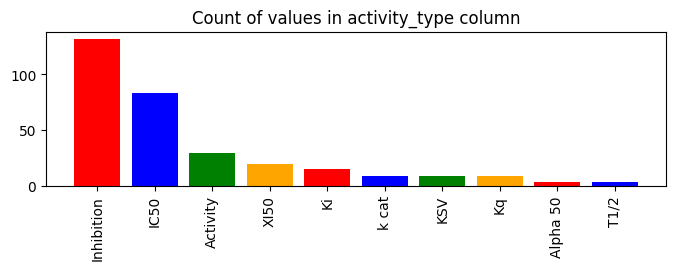

In [63]:
import matplotlib.pylab as plt 

def count_values(column, figsize=(8, 2), title=""):
    value_counts = column.value_counts().reset_index()
    value_counts.columns = ['Value', 'Count']
    plt.figure(figsize=figsize)
    fig = plt.bar(value_counts.Value, value_counts.Count, color=['red', 'blue', 'green', 'orange']);
    plt.xticks(rotation=90);   
    plt.title(title)
    return fig
    
count_values(df.standard_type, title="Count of values in activity_type column")


In [64]:
n_missing_smiles = df.query("canonical_smiles == None").shape[0]
n_missing_activity_values = df.query("standard_value == None").shape[0]
n_nan_smiles = df.canonical_smiles.isna().sum()
n_nan_activity = df.standard_value.isna().sum()

print("There are {0} missing SMILES and {1} missing activity values".format(n_missing_smiles, n_missing_activity_values))
print("There are {0} NaN SMILES and {1} NaN activity values".format(n_nan_smiles, n_nan_activity))

There are 0 missing SMILES and 0 missing activity values
There are 0 NaN SMILES and 66 NaN activity values


<BarContainer object of 11 artists>

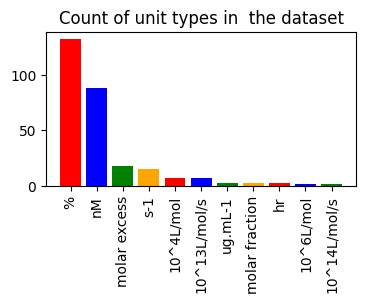

In [65]:
count_values(df.standard_units, figsize=(4, 2), title="Count of unit types in  the dataset")

<BarContainer object of 1 artists>

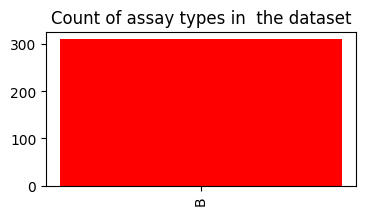

In [66]:
count_values(df.assay_type, figsize=(4, 2), title="Count of assay types in  the dataset")

<BarContainer object of 1 artists>

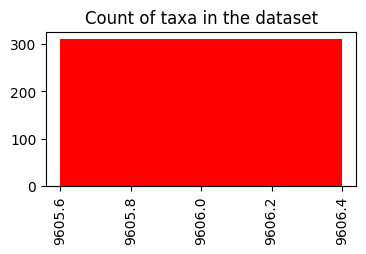

In [67]:
count_values(df.target_tax_id.astype(int), figsize=(4, 2), title="Count of taxa in the dataset")

Lots of things to unwrap here. Let's reflect and take a decision here. What should we do? 

In [68]:
def transform_standard_value(row):
    if row['standard_units'] == 'uM':
        return row['standard_value'] * 1000
    else:
        return row['standard_value']

def transform_standard_units(row):
    if row['standard_units'] == 'uM':
        return 'nM'
    else:
        return row['standard_units']

pipeline_df = (
    df.dropna(subset=['canonical_smiles'])  # Remove rows with NaN in 'canonical_smiles' column
      .dropna(subset=['standard_value'])     # Remove rows with NaN in 'standard_value' column
      .query("standard_type == 'IC50'")   # keep only IC50 types of assay
      .query("assay_type == 'B'")         # keep only binding assay type
      .query("standard_units != '%' or standard_units != 'degrees C' ")  # remove assays with non IC50 values
      .assign(standard_value=lambda x: x.apply(transform_standard_value, axis=1))  # transform uM to nM
      .assign(standard_units=lambda x: x.apply(transform_standard_units, axis=1))   # replace uM units with nM
      .drop_duplicates(subset=['canonical_smiles'])
)


### Transforming IC50 to pIC50

transforming IC50 values to -log10 is a common practice to express concentration values in terms of their negative logarithm. This transformation is essential for developing accurate QSAR models that relate variations in biological activity to variations in computed or measured properties of molecules. By converting IC50 values to -log10, you align the data with the free energy changes that occur during the biological response, enabling more meaningful analysis and prediction of compound activity.

$$ {PIC_{50}} = x - log_{10} (IC_{50}) $$

Where: 
* $x=3$ for $mM$
* $x=6$ for $\mu M$
* $x=9$ for $nM$
* $x=12$ for $pM$

Check out this nice blog by [Mark Navre](https://www.collaborativedrug.com/cdd-blog/why-using-pic50-instead-of-ic50-will-change-your-life) to know more about this transformation.

In [69]:
pipeline_df["pIC50"] = 9 - np.log10( pipeline_df.standard_value)

The dataframe can be reduced to the essential data that we will need to build the machine learning model. We will then generate a new dataframe that contains the SMILES structures and the activity data. At this level also, we may get rid of the duplicates in the dataset. We will dump the dataframe to a new CVS file called `training_dataset.csv` 

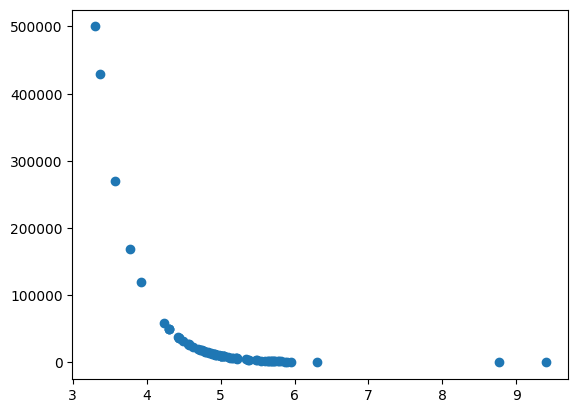

In [145]:
plt.scatter(pipeline_df["pIC50"], pipeline_df.standard_value )

In [70]:
training_dataset = pd.DataFrame({"SMILES": pipeline_df.canonical_smiles, "pIC50": pipeline_df.pIC50})
training_dataset.drop_duplicates().to_csv("../data/training_dataset.csv", index=False)


## Constructing the machine (ML) learning model

Now that the training data is ready we will start to build our QSAR model by following these steps:
1. Generating the feature matrix
2. Splitting the dataset
3. building the model
4. validating the mode

### Generating the feature matrix
Research findings in molecular characterization have successfully characterized many physicochemical attributes of ligands. These properties could be assigned to the molecular structure of a ligand and are commonly referred to as molecular descriptors. Various software tools can generate these descriptors utilizing the SMILES format. We have generated an intermediate output file in the last step as a chekpoint, so that if anything goes wrong you may start your notebook here. Let's first read the input file that contains the SMILES (your ligans' structures and the pCI50 activity values)

In [71]:
import pandas as pd
training_dataset = pd.read_csv("../data/training_dataset.csv")  # reads input data from CSV file
training_dataset

,SMILES,pIC50
0,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,5.000000
1,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,4.301030
2,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)c1ccccc1,4.301030
3,Cc1c(C(C)C)c(=O)on1C(=O)N1CCC[C@H](C)C1,4.301030
4,COc1nn(-c2ccc(NC(=O)c3ccc(C(C)(C)C)cc3)cc2)c(=...,5.000000
...,...,...
71,O=C1/C(=C/c2ccccc2)Oc2cc(OCCCCCCO)ccc21,5.045179
72,O=C1/C(=C/c2ccccc2)Oc2cc(OCCCCCCCCCCO)ccc21,5.210843
73,COc1ccc(/C=C2\Oc3cc(OCCCCCCCCCCO)ccc3C2=O)cc1OC,4.435808
74,COc1cc(/C=C2\Oc3cc(OCCCCCCCCCCO)ccc3C2=O)ccc1O,4.424004


Chemical descriptors are numerical values that quantify the structural and physicochemical properties of molecules in QSAR studies. They are used to capture the essential features of a molecule that are relevant to its biological activity, such as its shape, size, and electronic properties. There are many software and packages that could calculate molecular descriptors given a SMILES structure, each comes with its own set. Here we are using the `padelpy` python library.
You may notice from the code below, a line where I sub-sample the dataset. The reason is that calculating desciprtors could take alot of time to calculate. to speedup theprocess. in your case change `n` to `10`. and run the code.

In [72]:
from padelpy import from_smiles
import pandas as pd
from tqdm import tqdm
import numpy as np


desc_list = []

# calculate molecular descriptors
for smiles in tqdm(training_dataset.SMILES):
    desc = from_smiles(smiles, descriptors=True, fingerprints=False, threads = 2)
    transformed_dict = {k: float(v) if v else np.nan for k, v in desc.items()}  # by defaut padely generates string objects
    desc_list.append(transformed_dict)

padlpy_descriptors = pd.DataFrame(desc_list)
padlpy_descriptors.to_csv("../data/padlpy_descriptors.csv", index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [05:09<00:00,  4.08s/it]


In [21]:
ls ../data

70per_sim_kampferrol_chembl.csv  filtered_trainging_pim1.csv
collected_smiles.csv             linear_regression_model.joblib
collected_smiles_pim1.csv        padlpy_descriptors.csv
count_assay_kampferolsim70.csv   training_dataset.csv
descriptors_pim1.csv             training_dataset_pim1.csv


### Feature selection 
padelpy calculates 1875 descriptors. not all of them are relevant to our study. Besides, inluding all the calculated descriptors may harm the performance of the machine learning model and increase the calculation time. For such a reason, we need to perform *a feature selection* task. In our case, we will calculate the correlation coefficients between every descriptor and the pIC50 values.

In [73]:
from sklearn.metrics import r2_score
import pandas as pd
from tqdm import tqdm
import numpy as np

padlpy_descriptors = pd.read_csv("../data/padlpy_descriptors.csv")

def calculate_correlation_coefficient(list1, list2):
    correlation_coefficient = np.corrcoef(list1, list2)[0, 1]
    return correlation_coefficient

pearson_coef = []
cols = []
for column in tqdm(padlpy_descriptors.columns): 
    container_df = pd.DataFrame( {column:list(padlpy_descriptors[column]) , "pIC50": list(training_dataset.pIC50)} ).dropna() 
    pearson_coef.append(calculate_correlation_coefficient(container_df[column], container_df.pIC50))
    cols.append(column)

correlation_with_activity = pd.DataFrame({"descriptor_type":cols, "pearson_coef":pearson_coef} )
                                  


  0%|                                                                                                                                | 0/1875 [00:00<?, ?it/s]/media/houcem/theDrum/modules/miniconda3/envs/chemenv/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/media/houcem/theDrum/modules/miniconda3/envs/chemenv/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/media/houcem/theDrum/modules/miniconda3/envs/chemenv/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/media/houcem/theDrum/modules/miniconda3/envs/chemenv/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
 19%|██████████████████████▌                                                  

Let's check the statistics 

In [74]:
correlation_with_activity.pearson_coef.describe()

count    1588.000000
mean        0.138908
std         0.263046
min        -0.536211
25%        -0.063411
50%         0.114519
75%         0.341191
max         0.735824
Name: pearson_coef, dtype: float64

In [75]:
correlation_with_activity.head()

,descriptor_type,pearson_coef
0,nAcid,0.004624
1,ALogP,-0.148635
2,ALogp2,0.218736
3,AMR,0.349764
4,apol,0.421597


Now that we selected the different features, we can subset the original dataframe. This will be our final training/validation dataset

In [83]:
selected_features = list(correlation_with_activity.query("abs(pearson_coef) >=0.5").descriptor_type)
selected_descriptors = padlpy_descriptors[selected_features]
print("number of selected descriptors:  {0}".format(selected_descriptors.shape[1]))

number of selected descriptors:  165


### Removing low variance columns

In [85]:
from sklearn.feature_selection import VarianceThreshold

# VarianceThreshold transformer
threshold = 0.05  # Set your desired threshold here
selector = VarianceThreshold(threshold)
selector.fit(selected_descriptors)

# Get the columns to keep
columns_to_keep = selected_descriptors.columns[selector.get_support()]

# Filter the DataFrame
selected_descriptors_high_variance = selected_descriptors[columns_to_keep]

print("number of selected descriptors with high variances:  {0}".format(selected_descriptors_high_variance.shape[1]))

number of selected descriptors with high variances:  155


In [86]:
selected_descriptors_high_variance["pIC50"] = training_dataset.pIC50
selected_descriptors_high_variance = selected_descriptors_high_variance.dropna()
pIC50 =  list(selected_descriptors_high_variance.pIC50)
selected_descriptors_high_variance = selected_descriptors_high_variance.drop(columns=['pIC50'])


/tmp/ipykernel_20953/1889197881.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_descriptors_high_variance["pIC50"] = training_dataset.pIC50


In [104]:
selected_descriptors_high_variance.shape

(47, 155)

## Training the model

In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    selected_descriptors_high_variance,
    pIC50,
    test_size=0.2,
    random_state=42
)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = lr_model.predict(X_test_scaled)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.5922588659283701
R-squared: -7.6534646942689974


## saving and deploying the model
We can export the model

In [139]:
import joblib 
joblib.dump(lr_model, './data/linear_regression_model.joblib')

['./data/linear_regression_model.joblib']

We can then reuse it later

In [140]:
import joblib

# Load the model
loaded_model = joblib.load('./data/linear_regression_model.joblib')

let's now apply the model on the dataset from Faris et al.

In [151]:
mols = ["O=c1c(O)c(-c2cc(O)c(O)cc2S(=O)(=O)O)oc2cc(O)cc(O)c12",
"COc1ccc(-c2oc3c(OC)c(O)c(OC)c(O)c3c(=O)c2OC)cc1",
"O=c1c(O[C@H]2O[C@@H](CO)[C@@H](O)[C@@H]2O)c(-c2ccc(O)cc2)oc2cc(O)cc(O)c12"]

Let's draw these molecules using RdKit

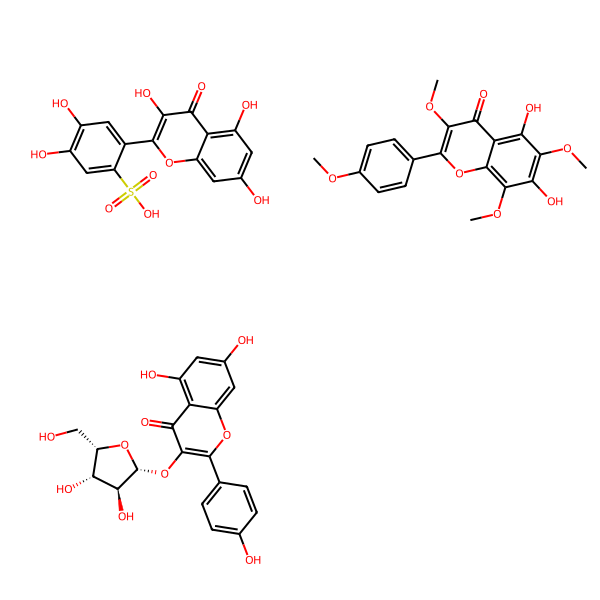

In [155]:
from rdkit import Chem
from rdkit.Chem import Draw

# Convert SMILES to RDKit molecule objects
molec = [Chem.MolFromSmiles(smi) for smi in mols]

# Draw them as a grid
Draw.MolsToGridImage(molec, molsPerRow=2, subImgSize=(300,300))

In [126]:
from padelpy import from_smiles
mydic = []
for smiles in tqdm(mols):
    desc = from_smiles(smiles, descriptors=True, fingerprints=False, threads = 2)
    transformed_dict = {k: float(v) if v else np.nan for k, v in desc.items()}
    mydic.append(transformed_dict)

zink_db_flav = pd.DataFrame(mydic)



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.01s/it]


The experimental pIC50 values are the following

In [141]:
# Select specific columns
columns_to_keep = list(selected_descriptors_high_variance.columns) # these are the same col ids used for the training 
zink_db_flav_selected = zink_db_flav.loc[:, columns_to_keep]  # Using DataFrame.loc
predictions = loaded_model.predict(zink_db_flav_selected)

/media/houcem/theDrum/modules/miniconda3/envs/chemenv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [134]:
diff2

[]